# 4章　MA過程
## あらすじ
前章で「一次差分が定常で自己相関がない系列」をランダムウォークであると言う話をしました。  
  
しかし、大体の定常プロセスは自己相関を示します。  
  
こういった自己相関が存在する系列に対しての予測をこれから学んで、実装していきます  
  
まずこの章では移動平均モデル(MA過程)について扱います。  
  
そしてMA過程を学んだあとに最終的に扱うデータはXYZ Widget Companyの製品売上高のデータです。  
  
この企業の目標は最適な製品製造量を知ることです。  
  
この目標を達成するためにはこの製品の売上を予測する必要があります。  
  
予測期間は後で出てきますが50日分です(取得データの10％)  
  
今回はデータ収集は済んでいるので省略します  
  
ではどのモデルが最適なのでしょうか？

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/widget_sales.csv')

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


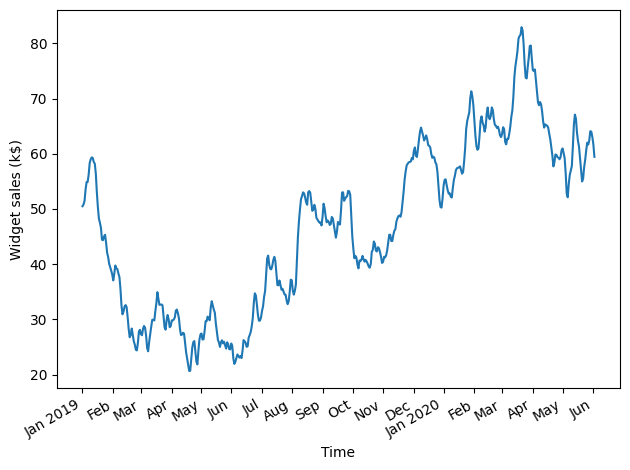

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F01_peixeiro.png', dpi=300)

## 移動平均過程
移動平均過程は現在の値が現在と過去の誤差校に線形従属しているモデルで、誤差項はホワイトノイズと想定されます。  
  
移動平均モデルはMA(q)でしばしば表されます。  
  
このモデルは一般に以下のような式で表される  
  
$$
y_{t}=\mu + \epsilon_{t}+\theta_{1} \epsilon_{t-1} +\theta_{2} \epsilon_{t-2}+\cdots +\theta_{q} \epsilon_{t-q}
$$
  
時系列の平均$\mu$、誤差項$\epsilon_{t-q}$の線形結合で、$\theta_{q}$は係数。  
  
なので例えばq=2のMA過程の式は  
  
$$
y_{t}=\mu +\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}
$$
で表されます  
  
このようにMA過程の式は次数によってモデルが決まります。  
  
ではその次数はどのようにして求めるのでしょうか？  
  
今回は次数特定のためにランダムウォークの識別の手順を拡張してみます。  
  
![alt text](pict4.png)
  
上の図はもとの図にMA過程かどうかを調べる手順を1つ加えただけです。  
  
先述したとおり今後は**時系列が定常であること**を前提として進んでいきます。  
  
なのでまずはランダムウォークと同様のテストを行い、定常性を確認します。  
  
では早速データを使って試してみましょう

In [4]:
df = pd.read_csv('../data/widget_sales.csv') #データの読み込み

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


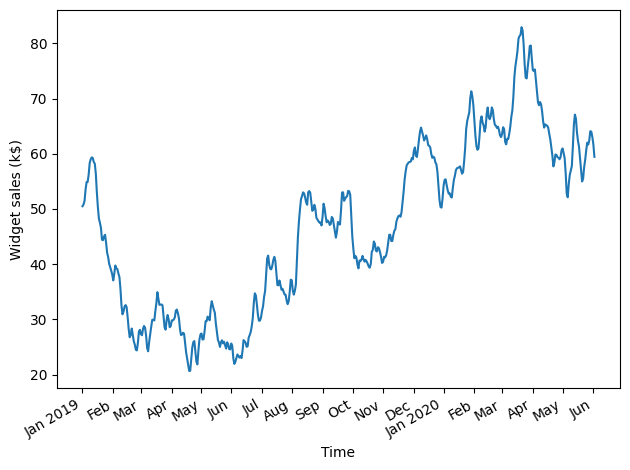

In [5]:
fig, ax = plt.subplots() # グラフの作成

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F01_peixeiro.png', dpi=300)

In [6]:
ADF_result = adfuller(df['widget_sales']) # ADF検定の実行

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


可視化した情報やADF統計量、p値を見ても帰無仮説を棄却できないため定常ではないと判断します。  
  
では手順通り一次差分をとってみましょう

In [7]:
widget_sales_diff = np.diff(df['widget_sales'], n=1) #1次差分

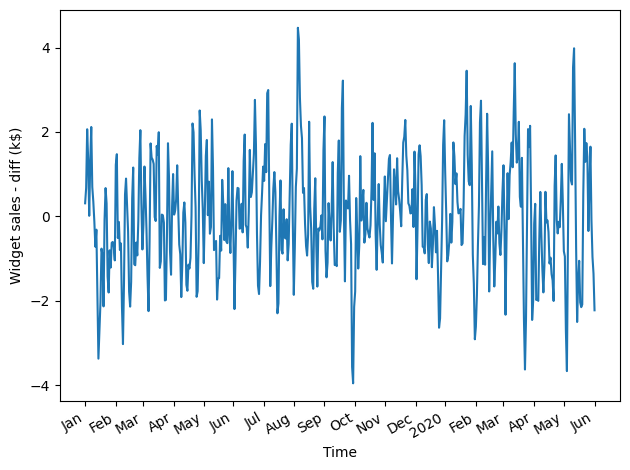

In [8]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F05_peixeiro.png', dpi=300)

In [9]:
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


可視化の情報からトレンドの成分が安定化し、またp値も小さいため定常であると言えそうです。  
  
では次は自己相関関数をプロットして相関の有無を確認しましょう

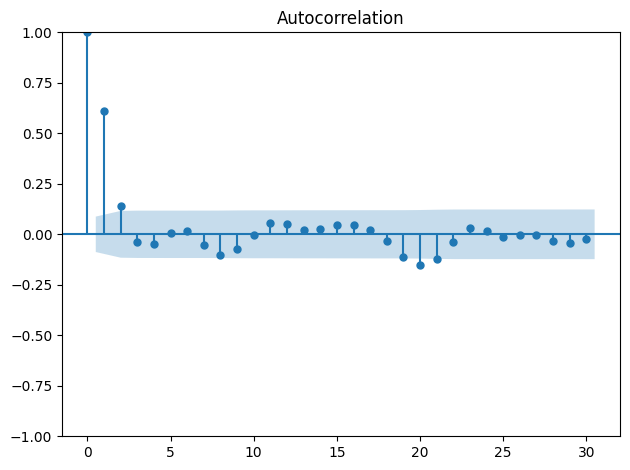

In [10]:
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()

plt.savefig('figures/CH04_F06_peixeiro.png', dpi=300)

ラグ0〜2までの値が影付きの領域から飛び出している、つまり、それらが有意であると読み取ることができます。  
  
つまりwidgetのデータの一次差分は2次のMA過程であると言うことがわかりました。

### MA過程を予測する
ここまででMA過程であること、次数が2であることがわかりました。  
  
あとはモデルを訓練して、予測するだけです。  
  
ただし、この予測で得られる値はあくまで変換後の値であることに注意してください。  
  
ではデータをtrain:test=9:1で分割します

In [11]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


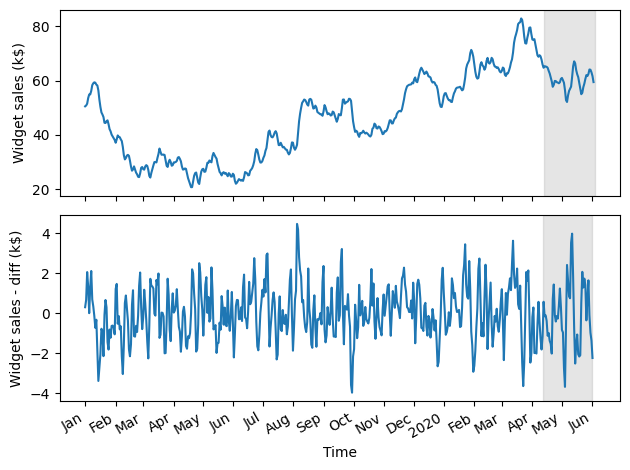

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F07_peixeiro.png', dpi=300)

MAモデルには予測期間に関して少し特殊な制限があります。  
  
それは一気に未来の50ステップを予測することができません。  
  
理由は式にあります  
  
$$
y_{t}=\mu +\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}
$$
  
このようにステップ分の誤差項しかないためステップ以上の予測ができません  
  
今回はステップ分の予測を繰り返すローリング予測として実装します。


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA': #要解説
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

rolling_forecast関数の引数は以下のとおりです
・df：扱う時系列データ  
・train_len：trainデータのサイズ  
・horizon：テストデータのサイズ  
・window：一度に予測するタイムステップの個数(window＜＝q)  
・method：予測手法の選択、今回は過去平均と最後の既知の値を使う"mean"と"last"そしてメインの"MA"が指定できます  
  
それぞれの引数を設定し、MA過程のローリング予測をしてみましょう。

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train) #訓練データの長さ
HORIZON = len(test) #テストデータの長さ
WINDOW = 2 #ウィンドウサイズ

# 予測の実行
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean') #平均による予測
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last') #最終値による予測
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA') #移動平均による予測

# 予測結果をデータフレームに格納
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


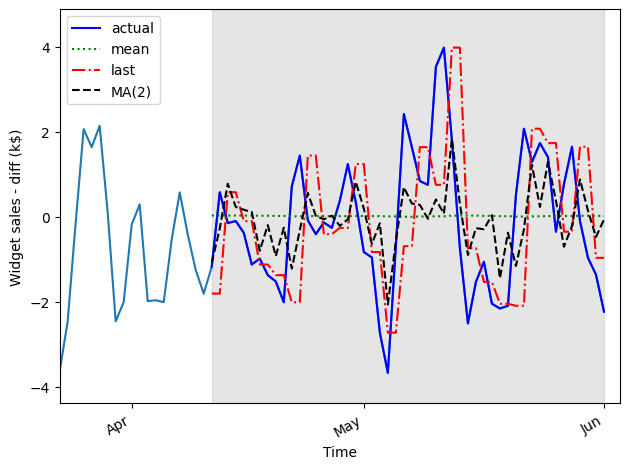

In [15]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F08_peixeiro.png', dpi=300)

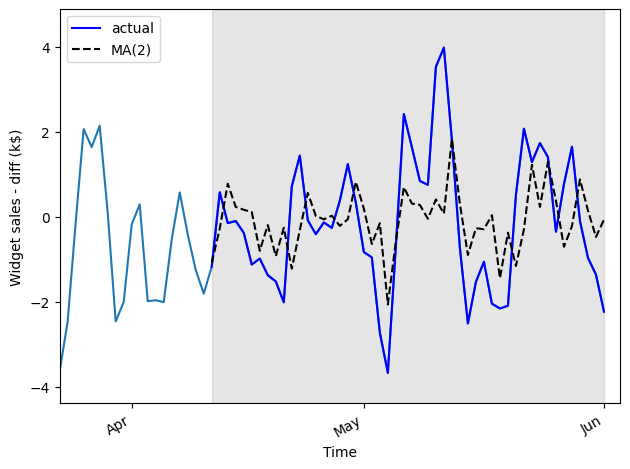

In [16]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(f'MSE mean: {mse_mean}')
print(f'MSE last: {mse_last}')
print(f'MSE MA: {mse_MA}')

MSE mean: 2.5606299456880537
MSE last: 3.2494260812249225
MSE MA: 1.9481714497863145


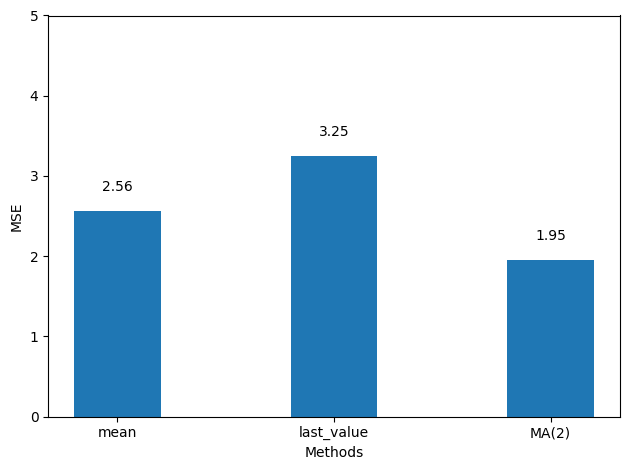

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)

このデータにはMA過程が一番フィットするというのがわかりました。  
  
しかし、これはあくまで実データの差分です。なので、この値をもとに戻すいわゆる逆変換をしないといけません。  
  
まずは式ベースで確認しましょう、今求めたいのは$y_{t}$とします。  
  
$$
y_{1}=y_{0}+y'_{1}\\
y_{2}=y_{0}+y'_{1}+y'_{2}\\
\\
\vdots\\
\\
y_{t}=y_{0}+y'_{1}+y'_{2}+\ldots+y'_{t}\\
y_{t}=y_{0}+\sum_{k=1}^{t}y'_{k}
$$
  
図示すると以下のようになります  
  
![alt text](pict5.png)  

In [24]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

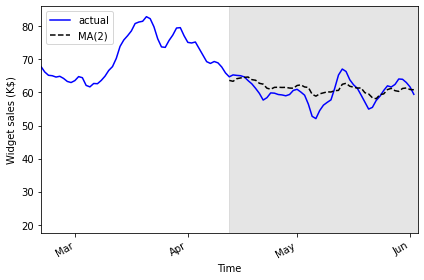

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498],
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F11_peixeiro.png', dpi=300)

In [26]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

2.324470924412907
